In [189]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_log_error


In [190]:
train_data=pd.read_csv("./data/train.csv")
test_data=pd.read_csv("./data/test.csv")

# Encode categorical features using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = ["Sex"]
one_hot_encoded = encoder.fit_transform(train_data[categorical_columns])
one_hot_encoded_test = encoder.transform(test_data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns))
one_hot_df_test = pd.DataFrame(one_hot_encoded_test, 
                          columns=encoder.get_feature_names_out(categorical_columns))
train_data = pd.concat([train_data.drop(categorical_columns, axis=1), one_hot_df], axis=1)
test_data = pd.concat([test_data.drop(categorical_columns, axis=1), one_hot_df_test], axis=1)
train_data['BMI'] = train_data['Weight'] / ((train_data['Height'] / 100) ** 2)
test_data['BMI'] = test_data['Weight'] / ((test_data['Height'] / 100) ** 2)

train_data_proc=train_data.drop(columns=['id'])
test_data_proc=test_data.drop(columns=['id'])

In [202]:
def find_duplicates(df):
    duplicates = df[df.duplicated(keep=False)]
    return duplicates

duplicates = find_duplicates(train_data_proc.drop(columns=['Calories']))

def remove_duplicates(df):
    df = df.drop_duplicates()
    return df

train_data_proc = remove_duplicates(train_data_proc)
print(train_data_proc)

        Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories  \
0        36   189.0    82.0      26.0       101.0       41.0     150.0   
1        64   163.0    60.0       8.0        85.0       39.7      34.0   
2        51   161.0    64.0       7.0        84.0       39.8      29.0   
3        20   192.0    90.0      25.0       105.0       40.7     140.0   
4        38   166.0    61.0      25.0       102.0       40.6     146.0   
...     ...     ...     ...       ...         ...        ...       ...   
749995   28   193.0    97.0      30.0       114.0       40.9     230.0   
749996   64   165.0    63.0      18.0        92.0       40.5      96.0   
749997   60   162.0    67.0      29.0       113.0       40.9     221.0   
749998   45   182.0    91.0      17.0       102.0       40.3     109.0   
749999   39   171.0    65.0      19.0        97.0       40.6     103.0   

        Sex_female  Sex_male        BMI            bin  
0              0.0       1.0  22.955684  (77.0, 314.0]

# routeur

In [191]:
print(train_data_proc.columns)

Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories', 'Sex_female', 'Sex_male', 'BMI'],
      dtype='object')


In [ ]:
train_data_proc['bin']=pd.qcut(train_data_proc['Calories'], q=1)
bin_list=train_data_proc['bin'].unique().tolist()
print(train_data_proc['bin'].value_counts())

bin
(0.999, 77.0]    375963
(77.0, 314.0]    371196
Name: count, dtype: int64


In [204]:
x_train, x_val, y_train, y_val = train_test_split(train_data_proc, train_data_proc[["Calories", "bin"]], test_size=0.2, random_state=42)
y_train["Calories"] = y_train["Calories"].apply(lambda x: 0 if x == 0 else np.log(1+x))
y_val["Calories"] = y_val["Calories"].apply(lambda x: 0 if x == 0 else np.log(1+x))

In [168]:
x_train_router = x_train.drop(columns=["Calories", "bin"])
y_train_router = y_train.drop(columns=["bin"])
x_val_router = x_val.drop(columns=["Calories", "bin"])
y_val_router = y_val.drop(columns=["bin"])

router = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric="rmsle",
    early_stopping_rounds=10,
    random_state=42
)
router.fit(x_train_router, y_train_router,
          eval_set=[(x_val_router, y_val_router)], verbose=True)

[0]	validation_0-rmsle:0.19803
[1]	validation_0-rmsle:0.18204
[2]	validation_0-rmsle:0.16747
[3]	validation_0-rmsle:0.15415
[4]	validation_0-rmsle:0.14390
[5]	validation_0-rmsle:0.13241
[6]	validation_0-rmsle:0.12247
[7]	validation_0-rmsle:0.11290
[8]	validation_0-rmsle:0.10425
[9]	validation_0-rmsle:0.09650
[10]	validation_0-rmsle:0.08936
[11]	validation_0-rmsle:0.08297
[12]	validation_0-rmsle:0.07708
[13]	validation_0-rmsle:0.07192
[14]	validation_0-rmsle:0.06737
[15]	validation_0-rmsle:0.06316
[16]	validation_0-rmsle:0.05929
[17]	validation_0-rmsle:0.05592
[18]	validation_0-rmsle:0.05273
[19]	validation_0-rmsle:0.04996
[20]	validation_0-rmsle:0.04738
[21]	validation_0-rmsle:0.04496
[22]	validation_0-rmsle:0.04283
[23]	validation_0-rmsle:0.04110
[24]	validation_0-rmsle:0.03940
[25]	validation_0-rmsle:0.03764
[26]	validation_0-rmsle:0.03628
[27]	validation_0-rmsle:0.03492
[28]	validation_0-rmsle:0.03357
[29]	validation_0-rmsle:0.03238
[30]	validation_0-rmsle:0.03138
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [205]:
model_dic = {}
for i in range(len(bin_list)):
    mask_train = x_train["bin"] == bin_list[i]
    mask_val = x_val["bin"] == bin_list[i]
    
    x_subtrain = x_train[mask_train].drop(columns=['bin', 'Calories'], errors='ignore')
    x_subval = x_val[mask_val].drop(columns=['bin', 'Calories'], errors='ignore')
    
    y_subtrain = y_train[mask_train].drop(columns=['bin'])
    y_subval = y_val[mask_val].drop(columns=['bin'])
    print(f"Training model for bin {bin_list[i]} with {x_subtrain.shape[0]} samples.")

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=9,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,
        reg_alpha=0.1,
        reg_lambda=1,
        eval_metric="rmsle",
        early_stopping_rounds=10,
        random_state=42
    )
    
    # Entraînement du modèle sur les sous-ensembles
    model.fit(x_subtrain, y_subtrain,
              eval_set=[(x_subval, y_subval)], verbose=True)
    
    # Ajout du modèle au dictionnaire
    model_dic[bin_list[i]] = model
    print(f"Model for bin {bin_list[i]} trained.")

Training model for bin (77.0, 314.0] with 297095 samples.
[0]	validation_0-rmsle:0.04654
[1]	validation_0-rmsle:0.04205
[2]	validation_0-rmsle:0.03801
[3]	validation_0-rmsle:0.03438
[4]	validation_0-rmsle:0.03193
[5]	validation_0-rmsle:0.02907
[6]	validation_0-rmsle:0.02756
[7]	validation_0-rmsle:0.02499
[8]	validation_0-rmsle:0.02286
[9]	validation_0-rmsle:0.02097
[10]	validation_0-rmsle:0.01908
[11]	validation_0-rmsle:0.01750
[12]	validation_0-rmsle:0.01598
[13]	validation_0-rmsle:0.01478
[14]	validation_0-rmsle:0.01380
[15]	validation_0-rmsle:0.01286
[16]	validation_0-rmsle:0.01185
[17]	validation_0-rmsle:0.01096
[18]	validation_0-rmsle:0.01018
[19]	validation_0-rmsle:0.00949
[20]	validation_0-rmsle:0.00895
[21]	validation_0-rmsle:0.00841
[22]	validation_0-rmsle:0.00799
[23]	validation_0-rmsle:0.00763
[24]	validation_0-rmsle:0.00726
[25]	validation_0-rmsle:0.00695
[26]	validation_0-rmsle:0.00675
[27]	validation_0-rmsle:0.00651
[28]	validation_0-rmsle:0.00630
[29]	validation_0-rmsle:

In [220]:
def predict(data):
    router_pred = router.predict(data)
    router_pred = np.exp(router_pred) - 1
    router_pred = np.clip(router_pred, 0, 314)

    data_pred = data.copy() 
    data_pred["bin"] = pd.cut(router_pred, bins=sorted(bin_list), labels=sorted(bin_list), include_lowest=True)
    for bin, model in model_dic.items():
        idx = data_pred["bin"] == bin
        if idx.sum() > 0:
            model_pred = model.predict(data.loc[idx])
            data_pred.loc[idx, "Calories"] = np.exp(model_pred) - 1
            data_pred.loc[idx, "Calories"] = np.clip(data_pred.loc[idx, "Calories"], 0, 314)

    return data_pred["Calories"].tolist()


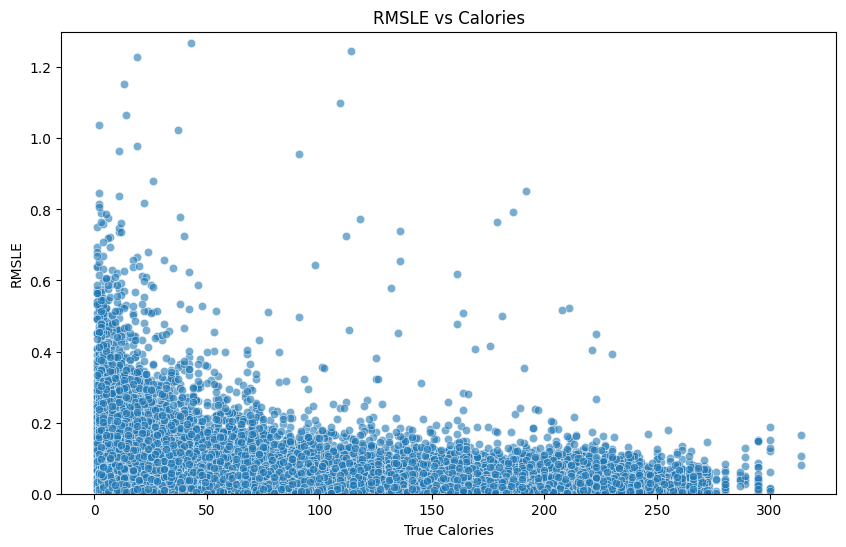

In [207]:
def plot_scatter_rmsle(y_true, y_pred):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    rmsle = np.sqrt(np.square(np.log1p(y_pred) - np.log1p(y_true)))

    data = pd.DataFrame({
        'Calories': y_true,
        'Predicted': y_pred,
        'RMSLE': rmsle
    })

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x="Calories", y="RMSLE", alpha=0.6)
    plt.title("RMSLE vs Calories")
    plt.xlabel("True Calories")
    plt.ylabel("RMSLE")
    plt.ylim((0,1.3))
    plt.show()

    return data

x_val_t=x_val.drop(columns=['bin','Calories'])
y_pred=predict(x_val_t)
y_pred = router.predict(x_val_t)
y_pred = np.exp(y_pred) - 1
y_val_eval = np.exp(y_val.drop(columns='bin'))-1

df = plot_scatter_rmsle(y_val_eval, y_pred)


In [208]:
rmsle=mean_squared_log_error(y_val_eval, y_pred)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.0037


In [221]:
y_pred = predict(test_data_proc)
print(len([pred for pred in y_pred if pred < 0]))
print(y_pred[:10])


0
[27.764188766479492, 107.85551452636719, 87.59674072265625, 125.72672271728516, 74.29430389404297, 21.63776397705078, 47.95721435546875, 6.848274230957031, 9.970381736755371, 205.0012664794922]


In [222]:
missing_rows = y_pred[y_pred["Calories"].isnull()]
print(missing_rows)

TypeError: list indices must be integers or slices, not str

In [212]:
submission = pd.DataFrame({"id": test_data["id"], "Calories": y_pred})
submission.to_csv("submission_8.csv", index=False)